# Overview of the April 17 2021 event

### Get satellite location data

Note: Location data from SSCWebServices is of low resolution (1 min). Resolution can be improved by using the data from the satellite server directly.

In [ ]:
sats = ["elfina", "elfinb", "arase", "mms1", "goes16", "goes17", "noaa15", "noaa19"]

In [ ]:
import spacepy.toolbox

spacepy.toolbox.update(leapsecs=True)
# spacepy.toolbox.update(QDomni=True)

Retrieving leapseconds file ... 

'/Users/zijin/.spacepy/data'

In [ ]:
import spacepy
from spacepy import coordinates, irbempy, time, toolbox
from sscws.sscws import SscWs


def process_data(data, backend="IRBEM", extMag="T01STORM"):
    IRBEM_RE = 6371.2

    sat = data["Id"]
    time = pd.to_datetime(data["Time"]).tz_convert(None)
    x = data["Coordinates"][0]["X"] / IRBEM_RE
    y = data["Coordinates"][0]["Y"] / IRBEM_RE
    z = data["Coordinates"][0]["Z"] / IRBEM_RE
    coords = np.array([x, y, z]).T

    t = spacepy.time.Ticktock(data["Time"], "ISO")
    loci = spacepy.coordinates.Coords(coords, "GSE", carsph="car", use_irbem=True)
    Lm = spacepy.irbempy.get_Lm(t, loci, 90, extMag=extMag)
    # magequator=spacepy.irbempy.find_magequator(t,loci)

    return pd.DataFrame(
        {
            "Id": sat,
            "Time": pd.Series(time),
            "X": pd.Series(x),
            "Y": pd.Series(y),
            "Z": pd.Series(z),
            "Lshell": pd.Series(Lm["Lm"].flatten()).abs(),
            "MltE": pd.Series(Lm["MLT"].flatten()),
        },
    )


ssc = SscWs()
result = ssc.get_locations(sats, trange)

# Use a list comprehension to process data and store results in a list
data_frames = {data["Id"]: process_data(data, extMag="T89") for data in result["Data"]}

# Concatenate the data frames into a single DataFrame
df = pd.concat(data_frames.values())

pline = pdp.PdPipeline(
    [
        pdp.df["Angle"] << pdp.df["MltE"] * 15 / 360 * 2 * np.pi,
        pdp.df["EquatorX"]
        << pdp.df["Lshell"] * (pdp.df["MltE"] * 15 / 360 * 2 * np.pi).map(np.cos),
        pdp.df["EquatorY"]
        << pdp.df["Lshell"] * (pdp.df["MltE"] * 15 / 360 * 2 * np.pi).map(np.sin),
    ]
)

df = pline.apply(df)
for _sat, _df in data_frames.items():
    data_frames.update({_sat: pline.SetIndex("Time").apply(_df)})

08-Sep-23 11:15:29: /Users/zijin/.local/lib/python3.10/site-packages/spacepy/omni.py:418: UserWarning: Qin-Denton/OMNI2 data not found in current format. This module has limited functionality. Run spacepy.toolbox.update(QDomni=True) to download data.
  warnings.warn(


In [ ]:
os.mkdir("data")

df.to_pickle("data/orbit_overview.pkl")

with open("data/orbit_data_frames.pickle", "wb") as handle:
    pickle.dump(data_frames, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
with open("data/orbit_data_frames.pickle", "rb") as handle:
    data_frames = pickle.load(handle)

df = pd.read_pickle("data/orbit_overview.pkl")

### Inspection of the satellite orbit and sketch plot

In [ ]:
# df.hvplot("Time", "Lshell", by="Id", subplots=True) * df.hvplot("Time", "MltE", by="Id", subplots=True)

# plot individual satellites
xlim = (-15, 15)
ylim = (-15, 15)
sat_plot = df.hvplot.scatter(
    x="EquatorX",
    y="EquatorY",
    by="Id",
    subplots=True,
    aspect=1,
    xlim=xlim,
    ylim=ylim,
    hover_cols=["Time"],
)
earth = hv.Ellipse(0, 0, 2)
ellipses = hv.Overlay(
    [hv.Ellipse(0, 0, s).opts(color="gray", alpha=0.2) for s in range(6, 38, 4)]
)

# sat_plot.opts( )
sat_plot * earth * ellipses

In [ ]:
# adjust mms1 time to be the same as elfinb
df.loc[df["Id"] == "mms1", "Time"] = df.loc[df["Id"] == "elfinb", "Time"]

time_plot = df.hvplot.scatter(
    x="EquatorX", y="EquatorY", by="Id", groupby="Time", aspect=1
)
time_plot.opts(aspect=1, xlim=xlim, ylim=ylim)

dt_range = pn.widgets.DateRangeSlider(
    name="Date Range Slider",
    start=df.Time.unique()[0],
    end=df.Time.unique()[-1],
    format="%H:%M:%S",
)

dfi = df.interactive()
timerange_plot = dfi[
    (dfi.Time >= dt_range.param.value_start) & (dfi.Time <= dt_range.param.value_end)
].hvplot.line(x="EquatorX", y="EquatorY", by="Id", aspect=1, xlim=xlim, ylim=ylim)
timerange_plot.opts()
pn.Row(time_plot * earth * ellipses, timerange_plot * earth * ellipses)

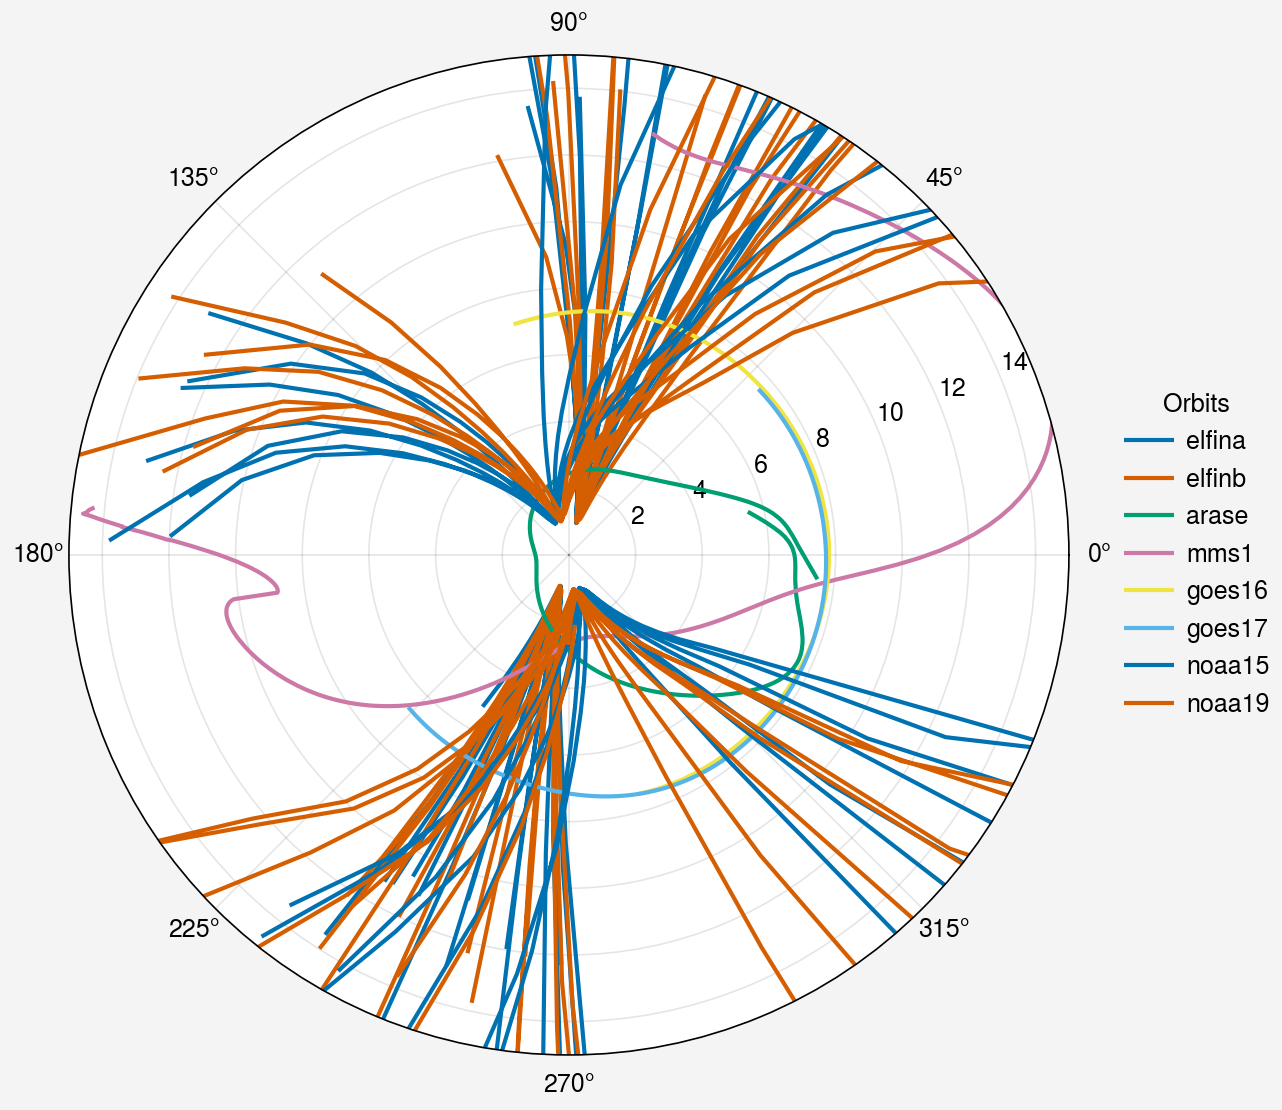

In [ ]:
groups = df.groupby("Id")
data = pd.concat({name: group.drop(columns="Id") for name, group in groups}, axis=1)

fig = pplt.figure(refwidth=5)
ax = fig.subplot(proj="polar")

ax.plot(
    data.loc[:, (sats, "MltE")] * 15 / 360 * 2 * np.pi,
    data.loc[:, (sats, "Lshell")],
    labels=sats,
)

ax.format(rlim=(0, 15))
ax.legend(loc="r", label="Orbits", ncols=1, frame=False)

## Plot of satellite orbits with highlight for interested time intervals (publication-quality)

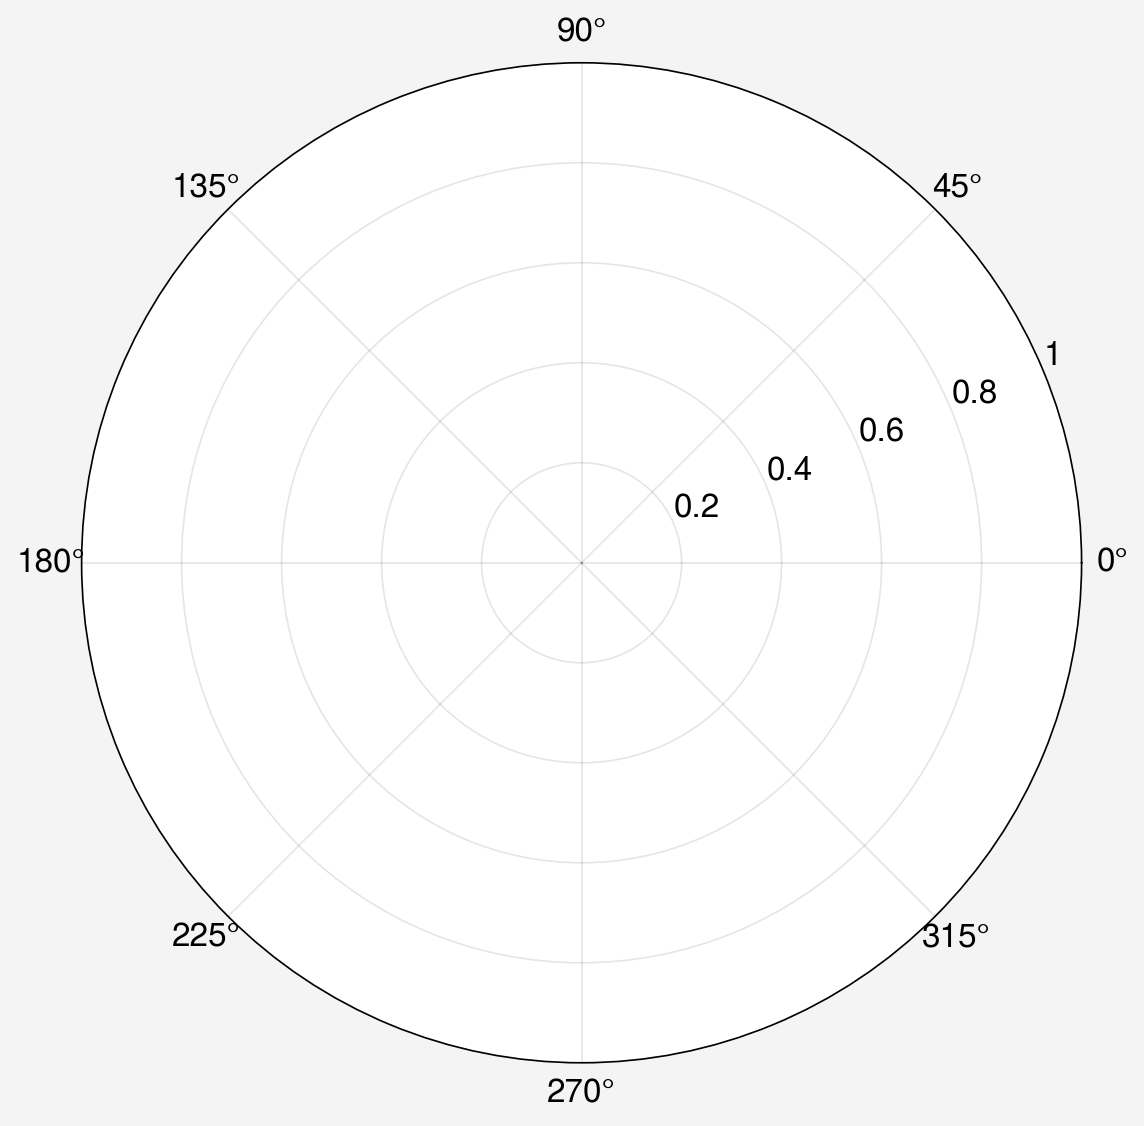

In [ ]:
# fig, ax = pplt.subplots(proj='polar', journal=journal)
fig, ax = pplt.subplots(proj='polar', refwidth=5)

color_name = "Qual1"
color_index = -1
alpha = 0.618

def ax_point(sat, time, text=True, scatter=True, marker="*"):
    time = pd.to_datetime(time)
    iloc_idx = data_frames[sat].index.get_indexer([time], method="nearest")[0]
    text_data = data_frames[sat].iloc[iloc_idx]
    rotation = text_data.Angle * 180 / np.pi
    if scatter:
        ax.scatter(
            text_data.Angle,
            text_data.Lshell,
            marker=marker,
            facecolors="None",
            edgecolors=(color_name, color_index),
        )
    if text:
        ax.text(
            text_data.Angle,
            text_data.Lshell + 1,
            time.strftime("%H:%M"),
            fontsize="small",
            rotation=rotation,
            rotation_mode="anchor",
            horizontalalignment="center",
            verticalalignment="center",
        )

In [ ]:
sat = "elfinb"
tranges = [
    ["2021-04-17 02:42:00", "2021-04-17 02:46:00"],
    ["2021-04-17 04:14:00", "2021-04-17 04:18:00"],
    ["2021-04-17 05:47:00", "2021-04-17 05:51:00"],
]
color_index += 1


# create a new DataFrame containing all the time ranges
# reindex the DataFrame with the new index to fill the missing rows with NaN values
# plot the reindexed DataFrame
df = pd.concat([data_frames[sat].loc[slice(*trange)] for trange in tranges]).reindex(
    data_frames[sat].index
)

ax.plot(
    "Angle",
    "Lshell",
    data=df,
    label="ELFIN-B",
    color=(color_name, color_index),
    alpha=alpha,
)

for time in np.array(tranges)[:, 0]:
    ax_point(sat, time)

for time in np.array(tranges)[:, 1]:
    ax_point(sat, time, text=False, marker="D")

# plot highlighted time ranges of interest
tranges = [
    ["2021-04-17 02:43:00", "2021-04-17 02:44:00"],
    ["2021-04-17 04:15:00", "2021-04-17 04:15:00"],
    ["2021-04-17 05:48:00", "2021-04-17 05:49:00"],
]

df = pd.concat([data_frames[sat].loc[slice(*trange)] for trange in tranges]).reindex(
    data_frames[sat].index
)

ax.plot(
    "Angle",
    "Lshell",
    data=df,
    label="",
    color=(color_name, color_index),
    lw=4,
)

<a list of 1 Line2D objects>

In [ ]:
""" This is commented out because of the low time resolution of the data from SSCWeb.
"""

if False:
    sat = "elfina"
    tranges = [
        ["2021-04-17 05:15:00", "2021-04-17 05:20:00"],
    ]
    color_index += 1

    # create a new DataFrame containing all the time ranges
    # reindex the DataFrame with the new index to fill the missing rows with NaN values
    # plot the reindexed DataFrame
    df = pd.concat(
        [data_frames[sat].loc[slice(*trange)] for trange in tranges]
    ).reindex(data_frames[sat].index)

    ax.plot(
        "Angle",
        "Lshell",
        data=df,
        label="ELFIN-B",
        color=(color_name, color_index),
        alpha=alpha,
    )

    for time in np.array(tranges)[:, 0]:
        ax_point(sat, time)

    for time in np.array(tranges)[:, 1]:
        ax_point(sat, time, text=False, marker="D")

    # plot highlighted time ranges of interest
    tranges = [
        ["2021-04-17 05:16:00", "2021-04-17 05:17:00"],
    ]

    df = pd.concat(
        [data_frames[sat].loc[slice(*trange)] for trange in tranges]
    ).reindex(data_frames[sat].index)

    ax.plot(
        "Angle",
        "Lshell",
        data=df,
        label="",
        color=(color_name, color_index),
        lw=4,
    )

In [ ]:
sat = "noaa19"
color_index += 1
tranges = [
    ["2021-04-17 01:47:00", "2021-04-17 01:52:00"],
    ["2021-04-17 03:30:00", "2021-04-17 03:36:00"],
]

df = pd.concat([data_frames[sat].loc[slice(*trange)] for trange in tranges]).reindex(
    data_frames[sat].index
)

ax.plot(
    "Angle",
    "Lshell",
    data=df,
    label="NOAA-19",
    color=(color_name, color_index),
    alpha=alpha,
)

for time in np.array(tranges)[:, 0]:
    ax_point(sat, time)

for time in np.array(tranges)[:, 1]:
    ax_point(sat, time, text=False, marker="D")

tranges = [
    ["2021-04-17 01:49:00", "2021-04-17 01:51:00"],
    ["2021-04-17 03:33:00", "2021-04-17 03:35:00"],
]

df = pd.concat([data_frames[sat].loc[slice(*trange)] for trange in tranges]).reindex(
    data_frames[sat].index
)

ax.plot(
    "Angle",
    "Lshell",
    data=df,
    label="",
    color=(color_name, color_index),
    lw=4,
)

<a list of 1 Line2D objects>

In [ ]:
sat = "noaa15"
color_index += 1

tranges = [
    ["2021-04-17 01:15:00", "2021-04-17 01:20:00"],
    ["2021-04-17 02:58:00", "2021-04-17 03:03:00"],
    # ["2021-04-17 04:39:00", "2021-04-17 04:44:00"],
]

df = pd.concat([data_frames[sat].loc[slice(*trange)] for trange in tranges]).reindex(
    data_frames[sat].index
)

ax.plot(
    "Angle",
    "Lshell",
    data=df,
    label="NOAA-15",
    color=(color_name, color_index),
    alpha=alpha,
)

for time in np.array(tranges)[:, 0]:
    ax_point(sat, time)

for time in np.array(tranges)[:, 1]:
    ax_point(sat, time, text=False, marker="D")

tranges = [
    ["2021-04-17 01:17:00", "2021-04-17 01:19:00"],
    ["2021-04-17 02:59:00", "2021-04-17 03:02:00"],
    # ["2021-04-17 04:41:00", "2021-04-17 04:43:00"],
]

df = pd.concat([data_frames[sat].loc[slice(*trange)] for trange in tranges]).reindex(
    data_frames[sat].index
)

ax.plot(
    "Angle",
    "Lshell",
    data=df,
    label="",
    color=(color_name, color_index),
    lw=4,
)

<a list of 1 Line2D objects>

In [ ]:
sat = "goes16"
color_index += 1

tranges = [
    ["2021-04-17 00:00:00", "2021-04-17 12:00:00"],
]
df = pd.concat([data_frames[sat].loc[slice(*trange)] for trange in tranges]).reindex(
    data_frames[sat].index
)
ax.plot(
    "Angle",
    "Lshell",
    data=df,
    label="GOES-16",
    color=(color_name, color_index),
    alpha=alpha,
)
for time in np.array(tranges)[:, 0]:
    ax_point(sat, time)

for time in np.array(tranges)[:, 1]:
    ax_point(sat, time, text=False, marker="D")

tranges = [
    ["2021-04-17 02:00:00", "2021-04-17 02:30:00"],  # ion injection
    ["2021-04-17 04:00:00", "2021-04-17 04:30:00"],  # electron injection
    ["2021-04-17 07:00:00", "2021-04-17 07:30:00"],  # electron injection
]

df = pd.concat([data_frames[sat].loc[slice(*trange)] for trange in tranges]).reindex(
    data_frames[sat].index
)

ax.plot(
    "Angle",
    "Lshell",
    data=df,
    label="",
    color=(color_name, color_index),
    lw=4,
)

for time in np.array(tranges).flatten():
    ax_point(sat, time, scatter=False)

In [ ]:
# ! NOTE: mms1 obtained Lm does not agree with the one provided (doesn't matter for this plot)
sat = "mms1"
color_index += 1


tranges = [
    ["2021-04-17 00:00:00", "2021-04-17 12:00:00"],
]
df = pd.concat([data_frames[sat].loc[slice(*trange)] for trange in tranges]).reindex(
    data_frames[sat].index
)

ax.plot(
    "Angle",
    "Lshell",
    data=df,
    label="MMS-1",
    color=(color_name, color_index),
    alpha=alpha,
)

for time in np.array(tranges)[:, 0]:
    ax_point(sat, time)

for time in np.array(tranges)[:, 1]:
    ax_point(sat, time, text=False, marker="D")


tranges = [
    ["2021-04-17 04:30:00", "2021-04-17 04:45:00"],  # electron decrease
    ["2021-04-17 08:00:00", "2021-04-17 08:15:00"],  # electron injection
]

df = pd.concat([data_frames[sat].loc[slice(*trange)] for trange in tranges]).reindex(
    data_frames[sat].index
)

ax.plot(
    "Angle",
    "Lshell",
    data=df,
    label="",
    color=(color_name, color_index),
    lw=4,
)

for time in np.array(tranges).flatten():
    ax_point(sat, time, scatter=False)

In [ ]:
sat = "arase"
color_index += 1


tranges = [
    ["2021-04-17 00:00:00", "2021-04-17 12:00:00"],
]
df = pd.concat([data_frames[sat].loc[slice(*trange)] for trange in tranges]).reindex(
    data_frames[sat].index
)

ax.plot(
    "Angle",
    "Lshell",
    data=df,
    label="ARASE",
    color=(color_name, color_index),
    alpha=alpha,
)
for time in np.array(tranges)[:, 0]:
    ax_point(sat, time)

for time in np.array(tranges)[:, 1]:
    ax_point(sat, time, text=False, marker="D")

tranges = [
    ["2021-04-17 01:00:00", "2021-04-17 01:15:00"],  # electron injection
    ["2021-04-17 07:10:00", "2021-04-17 07:25:00"],  # electron injection
]

df = pd.concat([data_frames[sat].loc[slice(*trange)] for trange in tranges]).reindex(
    data_frames[sat].index
)

ax.plot(
    "Angle",
    "Lshell",
    data=df,
    label="",
    color=(color_name, color_index),
    lw=4,
)

for time in np.array(tranges).flatten():
    ax_point(sat, time, scatter=False)

In [ ]:
# create an array of angles from 0 to 2*pi
r = np.ones(1000)
theta = np.linspace(0, 2 * np.pi, 1000)

# plot the circle
ax.plot(theta, r, color="black", lw=0.5)

# fill the left half of the circle with black
ax.fill_between(theta, r, where=theta < np.pi / 2, color="black")
ax.fill_between(theta, r, where=theta > np.pi * 3 / 2, color="black")

In [ ]:
def degree_to_hour(degrees, pos):
    """A custom formatting function to convert degrees to hours"""
    hour = (degrees / 2 / np.pi) * 24
    return f"{int(hour)}"


ax.format(
    # title="Multi-mission orbits 2021-04-17 00:00 to 12:00 UTC",
    thetaformatter="func",
    thetaformatter_kw={"func": degree_to_hour},
    rlim=(0, 15),
    rlabelpos=135,
)

ax.legend(loc="r", ncols=1, frame=False, title="Orbits")

fig

In [ ]:
# fig.savefig("../figures/orbit_multi_mission_conjunctions_T89_V4.svg")